In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import neighbors
from sklearn.metrics import classification_report

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

data_google_id = '1ZmMHa_lD1eYCEbluLrRYYiTHuiyhXK8F'
gdd.download_file_from_google_drive(file_id=data_google_id, 
                                    dest_path = './new_manipulated_usp_data.csv', 
                                    showsize = True)

data_google_id2 = '1TmInpL1cXCxbbMJqiWnSuevsRy5ovbIn'
gdd.download_file_from_google_drive(file_id=data_google_id2, 
                                    dest_path = './BDIP_Mama_INTELI.xlsx', 
                                    showsize = True)

data_base = pd.read_csv("new_manipulated_usp_data.csv")
data_os = pd.read_excel("BDIP_Mama_INTELI.xlsx")

data_os = data_os.drop_duplicates('record_id', keep = 'first', ignore_index = True)
data_os = data_os['output_os']

data_base = data_base.assign(output_os = data_os)
data_base = data_base.dropna(axis = 0)

320.0 KiB Done.
2.4 MiB Done.


In [ ]:
life_data = data_base.drop(data_base[(data_base.ultinfo == 1) | (data_base.ultinfo == 3) | (data_base.ultinfo == 4)].index)

In [ ]:
death_data = data_base.drop(data_base[(data_base.ultinfo == 1) | (data_base.ultinfo == 2) | (data_base.ultinfo == 4)].index)

Decidimos testar o modelo para pessoas que estão vivas sem câncer e para pessoas que vieram a óbito por câncer, além de todos juntos, a fim de analisar se os resultados são semelhantes ou se há comportamentos distintos.

#Todos os dados

Os modelos foram escolhidos a partir da sua acurácia e do número de falsos Low OS (falsos positivos). Essas métricas foram escolhidas pois supomos que é pior predizer que o risco da paciente é baixo mas na realidade é alto. Além disso, a acurácia engloba todos os tipos de acertos e erros, representando a assertividade do modelo de forma completa.

###KNN

O modelo KNN leva em consideração a classificação dos pontos mais próximos para determinar a classificação do novo ponto.

Ele foi escolhido por não ter uma acurácia tão baixa e por ter o menor erro em predizer High OS como Low OS.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.61      0.71      0.66       572
      Low OS       0.65      0.54      0.59       559

    accuracy                           0.63      1131
   macro avg       0.63      0.63      0.63      1131
weighted avg       0.63      0.63      0.63      1131



High OS    572
Low OS     559
Name: output_os, dtype: int64

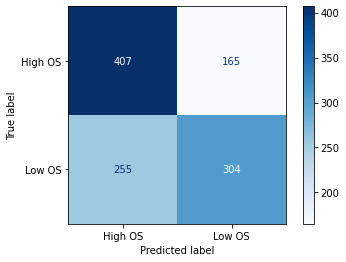

In [ ]:
x = data_base.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_knn = neighbors.KNeighborsClassifier(n_neighbors = 6).fit(x_train, y_train)

y_pred = model_knn.predict(x_test)

matriz = plot_confusion_matrix(model_knn, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

y_test.value_counts()

##Random Forest

O modelo Random Forest cria várias árvores de decisão, uma estrutura similar a um fluxograma, com “nós” onde uma condição é verificada, e se atendida o fluxo segue por um ramo, caso contrário, por outro, sempre levando ao próximo nó, até a finalização da árvore. No fim há uma votação de um resultado final.

Ele foi escolhido por ter uma das melhores acurácias e um dos menores erros em predizer High OS como Low OS.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.64      0.67      0.66       572
      Low OS       0.65      0.61      0.63       559

    accuracy                           0.64      1131
   macro avg       0.64      0.64      0.64      1131
weighted avg       0.64      0.64      0.64      1131



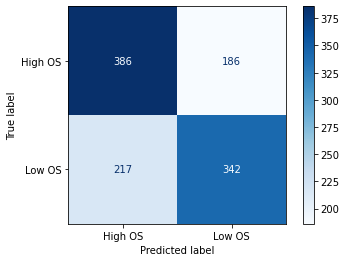

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelMin = RandomForestClassifier(criterion='entropy')
modelMin.fit(x_train, y_train)
yPredMin = modelMin.predict(x_test)

#f,gMin = plt.subplots(figsize=(100, 50))
#arvoreMin  = plot_tree(modelMin, rounded=True,ax=gMin,
              #feature_names=["pregnancy_history", "menarche", "diag_age", "period", "bmi", "hormone_therapy", "antec_fam_cancer_mama", "tobaco", "alcohol", "birads", "ultinfo", 'follow_up_days', 'primary_diganosis', 'histological_grade', 'grau_hist', 'tumor_subtype'])
matriz = plot_confusion_matrix(modelMin, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, yPredMin))

##Boosting

No Boosting os modelos são treinados com os mesmos datasets, porém os pesos das instâncias são ajustados de acordo com o erro das predições anteriores.

Ele foi escolhido por ter uma das melhores acurácias e um dos menores erros em predizer High OS como Low OS.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.64      0.69      0.66       572
      Low OS       0.66      0.61      0.63       559

    accuracy                           0.65      1131
   macro avg       0.65      0.65      0.65      1131
weighted avg       0.65      0.65      0.65      1131



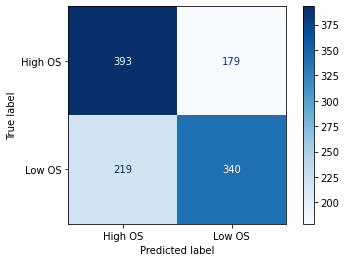

In [ ]:
from lightgbm import LGBMClassifier

# Dividindo x e y
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelLGBM = LGBMClassifier(n_estimators=100, random_state=0)
modelLGBM.fit(x_train, y_train)

y_pred = modelLGBM.predict(x_test)

matriz = plot_confusion_matrix(modelLGBM, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

Os modelos abaixo foram descartados por possuírem acurácias mais baixas ou por terem um erro maior em predizer High OS como Low OS.

##Bayes

              precision    recall  f1-score   support

     High OS       0.75      0.24      0.36       572
      Low OS       0.54      0.92      0.68       559

    accuracy                           0.57      1131
   macro avg       0.64      0.58      0.52      1131
weighted avg       0.64      0.57      0.52      1131



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


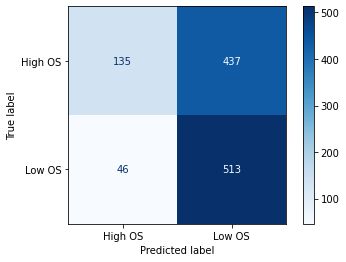

In [ ]:
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model = GaussianNB().fit(x_train, y_train)

y_pred = model.predict(x_test)

matriz = plot_confusion_matrix(model, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Árvore

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.59      0.60      0.59       572
      Low OS       0.58      0.58      0.58       559

    accuracy                           0.59      1131
   macro avg       0.59      0.59      0.59      1131
weighted avg       0.59      0.59      0.59      1131



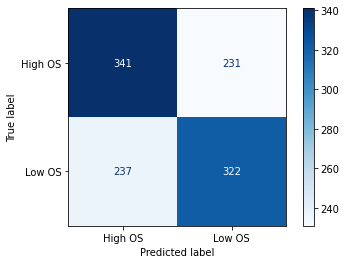

In [ ]:
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelMin = DecisionTreeClassifier(criterion='entropy')
modelMin.fit(x_train, y_train)
yPredMin = modelMin.predict(x_test)

#f,gMin = plt.subplots(figsize=(100, 50))
#arvoreMin  = plot_tree(modelMin, rounded=True,ax=gMin,
              #feature_names=["pregnancy_history", "menarche", "diag_age", "period", "bmi", "hormone_therapy", "antec_fam_cancer_mama", "tobaco", "alcohol", "birads", "ultinfo", 'follow_up_days', 'primary_diganosis', 'histological_grade', 'grau_hist', 'tumor_subtype'])
matriz = plot_confusion_matrix(modelMin, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, yPredMin))

##Regressão Logística

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.66      0.63      0.65       572
      Low OS       0.64      0.67      0.66       559

    accuracy                           0.65      1131
   macro avg       0.65      0.65      0.65      1131
weighted avg       0.65      0.65      0.65      1131



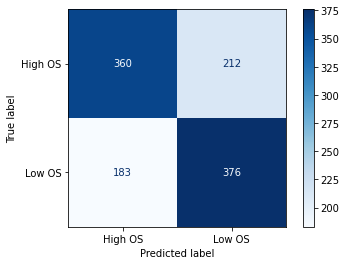

In [ ]:
from sklearn.linear_model import LogisticRegression

# Dividindo x e y
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Treinando o modelo
model_logistic = LogisticRegression(max_iter = 500).fit(x_train, y_train)

# Fazendo as predições
y_pred = model_logistic.predict(x_test)

matriz = plot_confusion_matrix(model_logistic, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.75      0.43      0.55       572
      Low OS       0.59      0.85      0.70       559

    accuracy                           0.64      1131
   macro avg       0.67      0.64      0.62      1131
weighted avg       0.67      0.64      0.62      1131



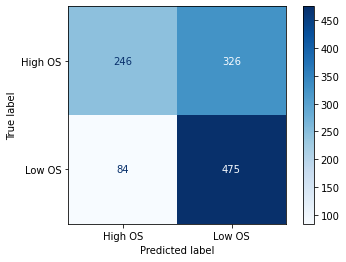

In [ ]:
from sklearn import svm
# Dividindo x e y
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Treinando o modelo
model_svm = svm.SVC().fit(x_train, y_train)

# Fazendo as predições
y_pred = model_svm.predict(x_test)

matriz = plot_confusion_matrix(model_svm, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Stacking

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

     High OS       0.68      0.63      0.65       572
      Low OS       0.65      0.69      0.67       559

    accuracy                           0.66      1131
   macro avg       0.66      0.66      0.66      1131
weighted avg       0.66      0.66      0.66      1131



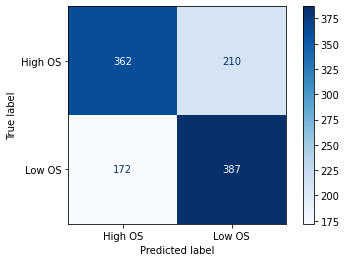

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Dividindo x e y
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_stacking = StackingClassifier(estimators=[('knn',model_knn), ('logistic',model_logistic)])
model_stacking.fit(x_train, y_train)

y_pred = model_stacking.predict(x_test)

matriz = plot_confusion_matrix(model_stacking, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Bagging

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.61      0.70      0.65       572
      Low OS       0.64      0.55      0.59       559

    accuracy                           0.63      1131
   macro avg       0.63      0.63      0.62      1131
weighted avg       0.63      0.63      0.62      1131



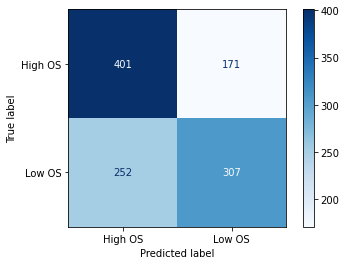

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Dividindo x e y
x = data_base.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = data_base['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_bagging = BaggingClassifier().fit(x_train, y_train)

y_pred = model_bagging.predict(x_test)

matriz = plot_confusion_matrix(model_bagging, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

#Pessoas vivas sem câncer

A partir do treinamento apenas com pessoas vivas foi possível identificar certos padrões. Os primeiros quatro modelos abaixo apresentaram maior taxa de erro nos falsos positivos (High OS como Low OS) enquanto os outros cinco apresentaram número de erros mais próximos entre falsos positivos e negativos.

Ao percebemos isso, criamos uma hipótese que o modelo acertou sim várias vezes, porém como `output_os` era relativo se a pessoa estava acima ou abaixo do `follow_up_days`, ele misturava várias categorias de expectativa de vida de várias pessoas.

Um bom exemplo visivel é que em `life_data` faz sentido muitos High OS (isto é, que possuíam risco gravíssimo de vida) serem classificados como Low OS, já que várias pessoas sobreviveram a luta contra o câncer, então fica mais fácil de predizer seu risco de vida.

##Bayes

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.61      0.09      0.16       387
      Low OS       0.49      0.94      0.65       363

    accuracy                           0.50       750
   macro avg       0.55      0.51      0.40       750
weighted avg       0.55      0.50      0.40       750



High OS    387
Low OS     363
Name: output_os, dtype: int64

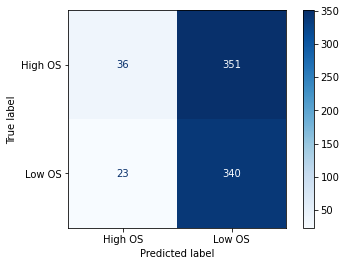

In [ ]:
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model = GaussianNB().fit(x_train, y_train)

y_pred = model.predict(x_test)

matriz = plot_confusion_matrix(model, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

y_test.value_counts()

##Regressão Logística

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.70      0.60      0.64       387
      Low OS       0.63      0.73      0.67       363

    accuracy                           0.66       750
   macro avg       0.66      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



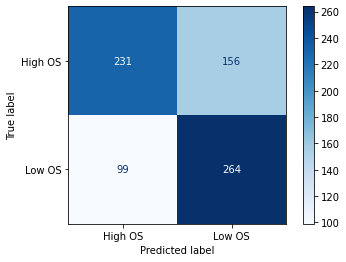

In [ ]:
from sklearn.linear_model import LogisticRegression

# Dividindo x e y
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Treinando o modelo
model_logistic = LogisticRegression(max_iter = 500).fit(x_train, y_train)

# Fazendo as predições
y_pred = model_logistic.predict(x_test)

matriz = plot_confusion_matrix(model_logistic, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.73      0.46      0.57       387
      Low OS       0.59      0.82      0.69       363

    accuracy                           0.64       750
   macro avg       0.66      0.64      0.63       750
weighted avg       0.66      0.64      0.62       750



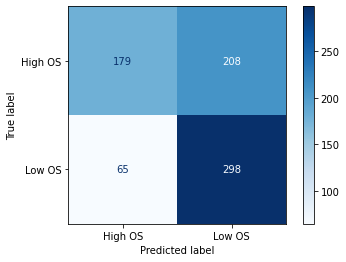

In [ ]:
from sklearn import svm
# Dividindo x e y
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Treinando o modelo
model_svm = svm.SVC().fit(x_train, y_train)

# Fazendo as predições
y_pred = model_svm.predict(x_test)

matriz = plot_confusion_matrix(model_svm, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Stacking

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.70      0.60      0.65       387
      Low OS       0.63      0.73      0.68       363

    accuracy                           0.66       750
   macro avg       0.67      0.66      0.66       750
weighted avg       0.67      0.66      0.66       750



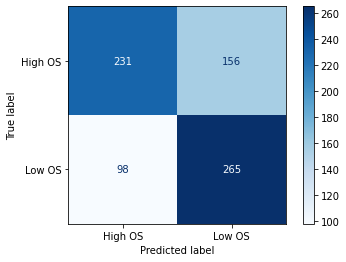

In [ ]:
# OBS: regressão logística e KNN devem ser rodados antes de rodar essa célula

from sklearn.ensemble import VotingClassifier, StackingClassifier

# Dividindo x e y
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_stacking = StackingClassifier(estimators=[('knn',model_knn), ('logistic',model_logistic)])
model_stacking.fit(x_train, y_train)

y_pred = model_stacking.predict(x_test)

matriz = plot_confusion_matrix(model_stacking, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Árvore

              precision    recall  f1-score   support

     High OS       0.62      0.60      0.61       387
      Low OS       0.59      0.61      0.60       363

    accuracy                           0.61       750
   macro avg       0.61      0.61      0.61       750
weighted avg       0.61      0.61      0.61       750



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


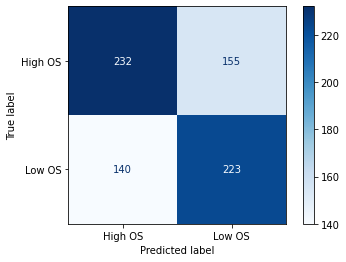

In [ ]:
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelMin = DecisionTreeClassifier(criterion='entropy')
modelMin.fit(x_train, y_train)
yPredMin = modelMin.predict(x_test)

#f,gMin = plt.subplots(figsize=(100, 50))
#arvoreMin  = plot_tree(modelMin, rounded=True,ax=gMin,
              #feature_names=["pregnancy_history", "menarche", "diag_age", "period", "bmi", "hormone_therapy", "antec_fam_cancer_mama", "tobaco", "alcohol", "birads", "ultinfo", 'follow_up_days', 'primary_diganosis', 'histological_grade', 'grau_hist', 'tumor_subtype'])
matriz = plot_confusion_matrix(modelMin, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, yPredMin))

## KNN

              precision    recall  f1-score   support

     High OS       0.65      0.70      0.67       387
      Low OS       0.65      0.59      0.62       363

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


High OS    387
Low OS     363
Name: output_os, dtype: int64

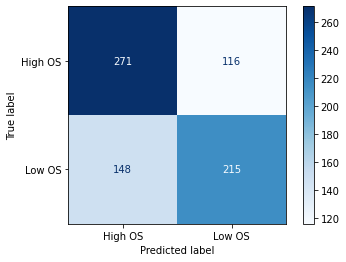

In [ ]:
x = life_data.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_knn = neighbors.KNeighborsClassifier(n_neighbors = 6).fit(x_train, y_train)

y_pred = model_knn.predict(x_test)

matriz = plot_confusion_matrix(model_knn, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

y_test.value_counts()

##Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.68      0.68      0.68       387
      Low OS       0.66      0.65      0.65       363

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.67       750



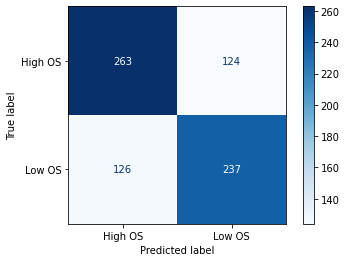

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelMin = RandomForestClassifier(criterion='entropy')
modelMin.fit(x_train, y_train)
yPredMin = modelMin.predict(x_test)

#f,gMin = plt.subplots(figsize=(100, 50))
#arvoreMin  = plot_tree(modelMin, rounded=True,ax=gMin,
              #feature_names=["pregnancy_history", "menarche", "diag_age", "period", "bmi", "hormone_therapy", "antec_fam_cancer_mama", "tobaco", "alcohol", "birads", "ultinfo", 'follow_up_days', 'primary_diganosis', 'histological_grade', 'grau_hist', 'tumor_subtype'])
matriz = plot_confusion_matrix(modelMin, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, yPredMin))

##Boosting

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.67      0.68      0.68       387
      Low OS       0.66      0.64      0.65       363

    accuracy                           0.66       750
   macro avg       0.66      0.66      0.66       750
weighted avg       0.66      0.66      0.66       750



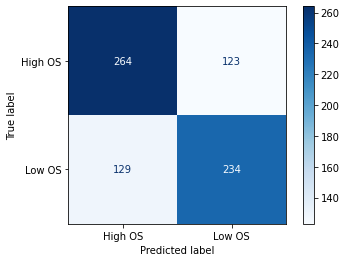

In [ ]:
from lightgbm import LGBMClassifier

# Dividindo x e y
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelLGBM = LGBMClassifier(n_estimators=100, random_state=0)
modelLGBM.fit(x_train, y_train)

y_pred = modelLGBM.predict(x_test)

matriz = plot_confusion_matrix(modelLGBM, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Bagging

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.65      0.69      0.67       387
      Low OS       0.65      0.61      0.63       363

    accuracy                           0.65       750
   macro avg       0.65      0.65      0.65       750
weighted avg       0.65      0.65      0.65       750



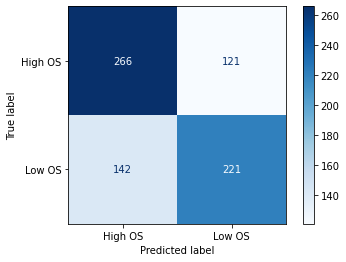

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Dividindo x e y
x = life_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = life_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_bagging = BaggingClassifier().fit(x_train, y_train)

y_pred = model_bagging.predict(x_test)

matriz = plot_confusion_matrix(model_bagging, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

#Pessoas que vieram a óbito por câncer

A partir do treinamento apenas com pessoas que vieram a óbito foi possível identificar um padrão. Oito dos nove modelos apresentaram maior taxa de erro nos falsos negativos (Low OS como High OS).

Ao percebemos isso, criamos uma hipótese que o modelo acertou sim várias vezes, porém como `output_os` era relativo se a pessoa estava acima ou abaixo do `follow_up_days`, ele misturava várias categorias de expectativa de vida de várias pessoas.

Um bom exemplo visivel é que em `death_data` faz sentido vários Low OS serem preditos como High OS, pois está levando em consideração somente dados de pessoas que vieram a óbito, então fica mais fácil de predizer seu risco de vida.

###KNN

              precision    recall  f1-score   support

     High OS       0.50      0.77      0.61       115
      Low OS       0.64      0.35      0.45       134

    accuracy                           0.54       249
   macro avg       0.57      0.56      0.53       249
weighted avg       0.57      0.54      0.52       249



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Low OS     134
High OS    115
Name: output_os, dtype: int64

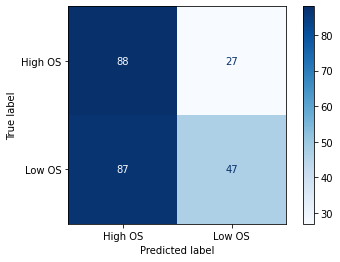

In [ ]:
x = death_data.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_knn = neighbors.KNeighborsClassifier(n_neighbors = 6).fit(x_train, y_train)

y_pred = model_knn.predict(x_test)

matriz = plot_confusion_matrix(model_knn, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

y_test.value_counts()

##Bayes

              precision    recall  f1-score   support

     High OS       0.50      0.85      0.63       115
      Low OS       0.69      0.28      0.39       134

    accuracy                           0.54       249
   macro avg       0.59      0.56      0.51       249
weighted avg       0.60      0.54      0.50       249



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


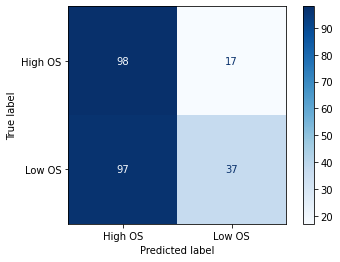

In [ ]:
x = death_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model = GaussianNB().fit(x_train, y_train)

y_pred = model.predict(x_test)

matriz = plot_confusion_matrix(model, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Árvore

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.50      0.55      0.52       115
      Low OS       0.58      0.53      0.55       134

    accuracy                           0.54       249
   macro avg       0.54      0.54      0.54       249
weighted avg       0.54      0.54      0.54       249



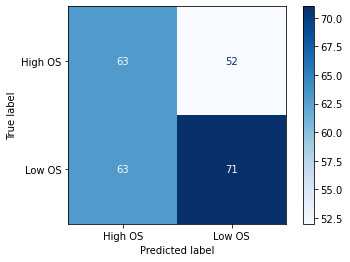

In [ ]:
x = death_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelMin = DecisionTreeClassifier(criterion='entropy')
modelMin.fit(x_train, y_train)
yPredMin = modelMin.predict(x_test)

#f,gMin = plt.subplots(figsize=(100, 50))
#arvoreMin  = plot_tree(modelMin, rounded=True,ax=gMin,
              #feature_names=["pregnancy_history", "menarche", "diag_age", "period", "bmi", "hormone_therapy", "antec_fam_cancer_mama", "tobaco", "alcohol", "birads", "ultinfo", 'follow_up_days', 'primary_diganosis', 'histological_grade', 'grau_hist', 'tumor_subtype'])
matriz = plot_confusion_matrix(modelMin, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, yPredMin))

##Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.54      0.68      0.60       115
      Low OS       0.64      0.50      0.56       134

    accuracy                           0.58       249
   macro avg       0.59      0.59      0.58       249
weighted avg       0.60      0.58      0.58       249



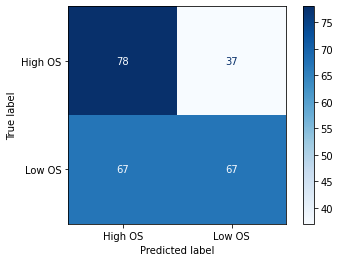

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x = death_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelMin = RandomForestClassifier(criterion='entropy')
modelMin.fit(x_train, y_train)
yPredMin = modelMin.predict(x_test)

#f,gMin = plt.subplots(figsize=(100, 50))
#arvoreMin  = plot_tree(modelMin, rounded=True,ax=gMin,
              #feature_names=["pregnancy_history", "menarche", "diag_age", "period", "bmi", "hormone_therapy", "antec_fam_cancer_mama", "tobaco", "alcohol", "birads", "ultinfo", 'follow_up_days', 'primary_diganosis', 'histological_grade', 'grau_hist', 'tumor_subtype'])
matriz = plot_confusion_matrix(modelMin, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, yPredMin))

##Regressão Logística

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

     High OS       0.56      0.65      0.60       115
      Low OS       0.65      0.56      0.60       134

    accuracy                           0.60       249
   macro avg       0.61      0.61      0.60       249
weighted avg       0.61      0.60      0.60       249



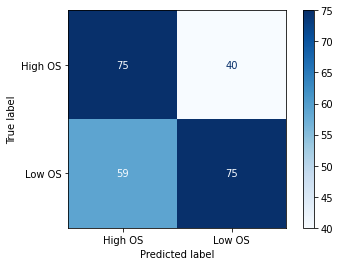

In [ ]:
from sklearn.linear_model import LogisticRegression

# Dividindo x e y
x = death_data.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Treinando o modelo
model_logistic = LogisticRegression(max_iter = 500).fit(x_train, y_train)

# Fazendo as predições
y_pred = model_logistic.predict(x_test)

matriz = plot_confusion_matrix(model_logistic, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##SVM

              precision    recall  f1-score   support

     High OS       0.61      0.40      0.48       115
      Low OS       0.60      0.78      0.68       134

    accuracy                           0.61       249
   macro avg       0.61      0.59      0.58       249
weighted avg       0.61      0.61      0.59       249



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


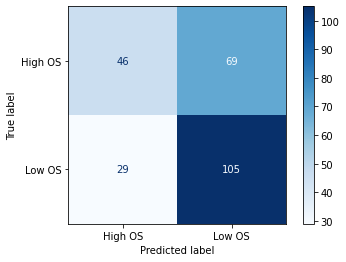

In [ ]:
from sklearn import svm
# Dividindo x e y
x = death_data.drop(columns=['record_id', 'output_os', 'follow_up_days_recidive', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# Treinando o modelo
model_svm = svm.SVC().fit(x_train, y_train)

# Fazendo as predições
y_pred = model_svm.predict(x_test)

matriz = plot_confusion_matrix(model_svm, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Stacking

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

     High OS       0.58      0.67      0.62       115
      Low OS       0.68      0.59      0.63       134

    accuracy                           0.63       249
   macro avg       0.63      0.63      0.63       249
weighted avg       0.63      0.63      0.63       249



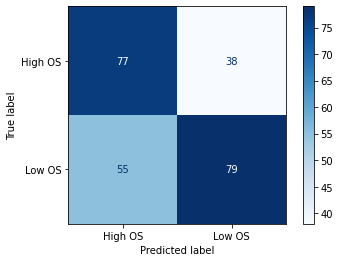

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

x = death_data.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_stacking = StackingClassifier(estimators=[('knn',model_knn), ('logistic',model_logistic)])
model_stacking.fit(x_train, y_train)

y_pred = model_stacking.predict(x_test)

matriz = plot_confusion_matrix(model_stacking, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))


##Boosting

              precision    recall  f1-score   support

     High OS       0.54      0.64      0.59       115
      Low OS       0.64      0.54      0.58       134

    accuracy                           0.59       249
   macro avg       0.59      0.59      0.59       249
weighted avg       0.59      0.59      0.59       249



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


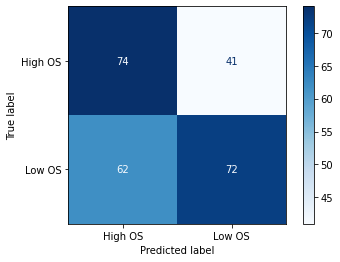

In [ ]:
from lightgbm import LGBMClassifier

x = death_data.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

modelLGBM = LGBMClassifier(n_estimators=100, random_state=0)
modelLGBM.fit(x_train, y_train)

y_pred = modelLGBM.predict(x_test)

matriz = plot_confusion_matrix(modelLGBM, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))

##Bagging

              precision    recall  f1-score   support

     High OS       0.53      0.73      0.62       115
      Low OS       0.66      0.45      0.53       134

    accuracy                           0.58       249
   macro avg       0.60      0.59      0.57       249
weighted avg       0.60      0.58      0.57       249



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


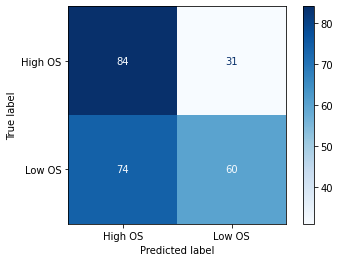

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Dividindo x e y
x = death_data.drop(columns=['record_id', 'output_os', 'progesteron_perct', 'er_percentage'])
y = death_data['output_os']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

model_bagging = BaggingClassifier().fit(x_train, y_train)

y_pred = model_bagging.predict(x_test)

matriz = plot_confusion_matrix(model_bagging, x_test, y_test, cmap = 'Blues', values_format='.0f')

print(classification_report(y_test, y_pred))